# Проект-3. Использование EDA для предсказания рейтинга отелей.

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import category_encoders as ce
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic

In [56]:
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sadeyes\AppData\Roaming\nltk_data...


True

In [2]:
hotels_train = pd.read_csv('data/hotels.csv')
hotels_test = pd.read_csv('data/hotels_test.csv')
sample_submission = pd.read_csv('data/submission.csv')

In [3]:
hotels_train['sample'] = 1
hotels_test['sample'] = 0
hotels_test['reviewer_score'] = 0

In [4]:
hotels = hotels_test.append(hotels_train, sort=False).reset_index(drop=True)
hotels.head(3)

C:\Users\sadeyes\AppData\Local\Temp\ipykernel_11096\950985444.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = hotels_test.append(hotels_train, sort=False).reset_index(drop=True)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыве;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

Посмотрим на тип данных.

In [5]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Пропущенные значения в признаках.

In [6]:
hotels.isnull().sum().sort_values(ascending=False)

lng                                           3268
lat                                           3268
hotel_address                                    0
additional_number_of_scoring                     0
sample                                           0
days_since_review                                0
tags                                             0
total_number_of_reviews_reviewer_has_given       0
review_total_positive_word_counts                0
positive_review                                  0
total_number_of_reviews                          0
review_total_negative_word_counts                0
negative_review                                  0
reviewer_nationality                             0
hotel_name                                       0
average_score                                    0
review_date                                      0
reviewer_score                                   0
dtype: int64

Выделим целевой признак в отдельную переменную.

In [ ]:
TARGET_FEATURE = hotels['reviewer_score']

## Добавим признак страны отеля и информацию о населении в стране каждого отеля

Посмотрим на пример строк из признака hotel_address, чтобы выделить оттуда важную информацию и увидеть структуру строк.

In [7]:
for i in range(0, 10, 2):
    display(hotels['hotel_address'].iloc[i])

'Via Senigallia 6 20161 Milan Italy'

'Mallorca 251 Eixample 08008 Barcelona Spain'

'Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands'

'Empire Way Wembley Brent London HA9 8DS United Kingdom'

'35 Rue Caumartin 9th arr 75009 Paris France'

Возьмем таблицу с Википедии о названии всех стран и соотношение населения к общему населению планеты.

In [8]:
countries_info = pd.read_html('https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population')[1]
total_population = countries_info['Population']['Numbers'].iloc[0]
countries_info['% of the world'] = countries_info['Population']['Numbers'] / total_population
countries_info = countries_info.sort_index(axis=1).drop(
    columns=['Date', 'Notes', 'Source (official or from the\xa0United Nations)', 'Rank', 'Population'],
    index=0).droplevel(level=1, axis=1).rename(
    columns={'% of the world': 'population_ratio',
             'Country / Dependency': 'country'}).sort_index(axis=1)
countries_info.head()

,country,population_ratio
1,China,0.176185
2,India,0.171672
3,United States,0.041731
4,Indonesia,0.034416
5,Pakistan,0.029431


Создадим признак *country*, в котором будет информация о стране, в которой располагается отель.

In [9]:
def get_country(address:str) -> str:
    
    """Returns existing country for raw address. If the country was not found, then returns none 

    Args:
        address (str): Raw address

    Returns:
        str: One of the existing countries
    """
    
    for country in countries_info['country'].to_list():
        if country in address:
            return country

hotels['country'] = hotels['hotel_address'].apply(get_country)
hotels = hotels.join(countries_info.set_index('country'), on='country')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country,population_ratio
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,0.007349
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,0.002221
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain,0.005942


## Заполняем пропущенные значения координат с помощью `geopy`

Посмотрим, в каких странах есть пропущенные значения.

In [10]:
countries_with_null = hotels[hotels['lat'].isna() | hotels['lng'].isna()]['country'].value_counts()
countries_with_null

Austria    2679
France      382
Spain       207
Name: country, dtype: int64

Можно заметить, что больше всего пропущенных значений находится в Австрии, а также есть во Франции и Испании.

Посмотрим на структуру адресов в этих странах, чтобы было проще заполнять пустые значения.

In [11]:
for country in countries_with_null.index:
    display(hotels[(hotels['lat'].isna() | hotels['lng'].isna()) 
                   & (hotels['country'] == country)].iloc[0].loc['hotel_address'])

'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria'

'23 Rue Damr mont 18th arr 75018 Paris France'

'Bail n 4 6 Eixample 08010 Barcelona Spain'

Видно, что последние 3 значения в строке представляют собой структуру *[postal code + city + country]*. Можем воспользоваться этой особенностью и заполнить пропущенные координаты с помощью библиотеки `geopy`.

Создадим отдельный датафрейм, который будет содержать в себе адрес, широту и долготу. Пропущенные значения заменим на строку, чтобы можно было заполнить эти значения с помощью метода `apply`, т.к. этот метод не работает с пропущенными (`NaN/None`) значениями.

In [12]:
address_coords = hotels[['hotel_address', 'lat', 'lng']].copy()
address_coords.fillna('unknown', inplace=True)
address_coords.head()

,hotel_address,lat,lng
0,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.16152
3,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644


Отобразим, как выглядят на данном этапе наши пропущенные значения, а потом сравним их после преобразования.

In [13]:
null_indexes = address_coords[address_coords['lat'] == 'unknown'].index
address_coords.iloc[null_indexes]

,hotel_address,lat,lng
35,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,unknown,unknown
293,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,unknown,unknown
476,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,unknown,unknown
526,23 Rue Damr mont 18th arr 75018 Paris France,unknown,unknown
569,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,unknown,unknown
...,...,...,...
515027,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,unknown,unknown
515400,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,unknown,unknown
515439,4 rue de la P pini re 8th arr 75008 Paris France,unknown,unknown
515637,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,unknown,unknown


Посмотрим на количество уникальных адресов.

In [14]:
address_coords.iloc[null_indexes]['hotel_address'].nunique()

17

Количество уникальных пропущенных адресов невелико, поэтому будем использовать запрос к [OpenStreetMap](https://www.openstreetmap.org/) с помощью библиотеки `geopy`.

In [15]:
# Создадим экземпляр класса Nominatim библиотеки geopy
geolocator = Nominatim(user_agent='project_3')
# Создадим экземпляр класса RateLimiter, чтобы ограничить задержку между запросами. В данном случае выполнение ячейки займет ~17 секунд
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def get_coords(address:str) -> tuple:
    
    """Returns the latitude and longitude for the address

    Args:
        address (str): Address

    Returns:
        tuple: (latitude, longitude)
    """
    
    # Сократим адрес до формата {почтовый индекс + город + страна}, т.к. в "сыром" формате библиотека geopy может не распознать местоположение
    def get_short_address(address:str) -> str:
        
        """Returns address in format '%postal_code %city %country'
        
        Args:
            address (str): Raw format of address, where last 3 words is '%postal_code %city %country'
            
        Returns:
            str: Short address
        """
        
        short_address = ' '.join(address.split()[-3:])
        return short_address
    
    location = geocode(get_short_address(address))
    lat = location.latitude
    lng = location.longitude
    
    return lat, lng

unique_null_addresses = address_coords.iloc[null_indexes]['hotel_address'].unique()
# Создадим словарь, где ключем будет полный адрес, а значением - кортеж из широты и долготы
filled_addresses_dict = dict()
for address in unique_null_addresses:
    filled_addresses_dict[address] = get_coords(address)

Мы создали словарь из 17 различных адресов(все из них имеют пропущенные значения широты и долготы), где значениями является кортеж (широта, долгота). Теперь надо заполнить наши пропущенные значения с помощью этого словаря.

In [16]:
def fill_coords(address:str, lat, lng, dictionary:dict) -> tuple:
    
    """Returns the latitude and longitude value for the address key. It is recommended to use in combination with the pandas.apply() method

    Args:
        address (str): Address
        lat (any): Empty latitude column to fill
        lng (any): Empty longitude column to fill
        dictionary (dict): Dictionary to fill in latitude and longitude 

    Returns:
        tuple: (address, new latitude, new longitude)
    """
    
    lat = dictionary[address][0]
    lng = dictionary[address][1]
    
    return address, lat, lng

address_coords.iloc[null_indexes] = address_coords.iloc[null_indexes].apply(
    lambda row: fill_coords(row['hotel_address'], row['lat'], row['lng'], filled_addresses_dict),
    axis=1,
    result_type='broadcast'
)

Выведем строки, которые были пустыми, после того, как получили их координаты.

In [17]:
address_coords.iloc[null_indexes]

,hotel_address,lat,lng
35,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,48.222757,16.356334
293,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,48.222757,16.356334
476,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,48.222757,16.356334
526,23 Rue Damr mont 18th arr 75018 Paris France,48.889485,2.342177
569,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,48.211029,16.347425
...,...,...,...
515027,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.214453,16.397042
515400,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.214453,16.397042
515439,4 rue de la P pini re 8th arr 75008 Paris France,48.873751,2.314978
515637,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.214453,16.397042


Заменим пустые значения координат в нашем основном датафрейме на преобразованные. Теперь у нас нет пропусков в данных.

In [18]:
filled_coords = address_coords[['lat', 'lng']].copy()
hotels[['lat', 'lng']] = filled_coords
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
country                                       0
population_ratio                              0
dtype: int64

Теперь нам больше не нужен признак с полным адресом отеля.

In [19]:
hotels.drop(columns='hotel_address', inplace=True)
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country,population_ratio
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,0.007349
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,0.002221
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.16152,0,0.0,Spain,0.005942


## Добавим признак с информацией о столице страны, в которой находится отель.

Возьмем таблицу столиц с Википедии. Добавим для каждой столицы широту и долготу.

In [22]:
capitals_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_national_capitals')[1]
capitals_df.drop(columns='Notes', axis=1, inplace=True)
capitals_df = capitals_df[capitals_df['Country/Territory'].isin(hotels['country'].unique())]
capitals_df = capitals_df.rename(columns={
    'City/Town': 'capital',
    'Country/Territory': 'country'
}).drop(index=13) # Удалим неофициальную столицу Нидерландов
capitals_df[['lat_cap', 'lng_cap']] = 'unknown'
# Удалим лишнюю информацию из названия столицы, например, приписку (official) 
capitals_df['capital'] = capitals_df['capital'].apply(lambda x: x.split()[0])
# Название города совпадает с названием страны, добавим уточнение для geopy, что Mexico в столбце capital - это город
capitals_df.loc[150]['capital'] = 'Mexico city' 
capitals_df

,capital,country,lat_cap,lng_cap
12,Amsterdam,Netherlands,unknown,unknown
134,London,United Kingdom,unknown,unknown
138,Madrid,Spain,unknown,unknown
150,Mexico city,Mexico,unknown,unknown
180,Paris,France,unknown,unknown
199,Rome,Italy,unknown,unknown
248,Vienna,Austria,unknown,unknown


Заполним значения координат для столиц немного измененной функцией из раздела заполнения пропущенных значений.

In [23]:
def get_capital_coords(address:str) -> tuple:
    
    """Returns the latitude and longitude for the city

    Args:
        address (str): City name

    Returns:
        tuple: (latitude, longitude)
    """
    
    location = geocode(address)
    lat = location.latitude
    lng = location.longitude
    
    return lat, lng

capital_coords = dict()
for capital in capitals_df['capital'].values:
    capital_coords[capital] = get_capital_coords(capital)

capitals_df[['capital', 'lat_cap', 'lng_cap']] = capitals_df[['capital', 'lat_cap', 'lng_cap']].apply(
    lambda row: fill_coords(row['capital'], row['lat_cap'], row['lng_cap'], capital_coords),
    axis=1,
    result_type='broadcast'
)
capitals_df

,capital,country,lat_cap,lng_cap
12,Amsterdam,Netherlands,52.37308,4.892453
134,London,United Kingdom,51.507322,-0.127647
138,Madrid,Spain,40.416705,-3.703582
150,Mexico city,Mexico,19.43263,-99.133178
180,Paris,France,48.85889,2.320041
199,Rome,Italy,41.89332,12.482932
248,Vienna,Austria,48.208354,16.372504


Присоединим к основному датафрейму данные о столицах.

In [24]:
hotels = hotels.join(capitals_df.set_index('country'), on='country')
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,days_since_review,lat,lng,sample,reviewer_score,country,population_ratio,capital,lat_cap,lng_cap
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,13 days,45.533137,9.171102,0,0.0,Italy,0.007349,Rome,41.89332,12.482932
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,234 day,52.385649,4.834443,0,0.0,Netherlands,0.002221,Amsterdam,52.37308,4.892453
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,616 day,41.393192,2.16152,0,0.0,Spain,0.005942,Madrid,40.416705,-3.703582


## Посчитаем расстояние между расположением отеля и столицей страны

In [ ]:
# Задание №4.4
def clean_tags(tags:str) -> list:
    stop_chars = ['[', ']', '\' ', ' \'']
    for char in stop_chars:
        tags = tags.replace(char, '')
    return tags.split(', ')
print('Количество уникальных тэгов:', hotels['tags'].apply(clean_tags).explode().nunique())
hotels['tags'].apply(clean_tags).explode().value_counts()

Напишем функцию, которая будет для каждой строки считать расстояние(в километрах) между городом отеля и столицей. Используем функциональность библиотеки `geopy`. А так же удалим признаки широты и долготы, т.к. это координаты и они не несут в себе смысла, ровно как и столбцы с любыми id.

In [32]:
def get_distance(lat_1:float, lng_1:float, lat_2:float, lng_2:float) -> float:
    
    """Returns distance between coordinates of 2 cities using 

    Args:
        lat_1 (float): latitude of first city
        lng_1 (float): longitude of first city
        lat_2 (float): latitude of second city
        lng_2 (float): longitude of second city

    Returns:
        float: Distance between 2 cities in kilometres
    """
    
    first_city = (lat_1, lng_1)
    second_city = (lat_2, lng_2)
    return geodesic(first_city, second_city).km
    
hotels['distance_to_capital'] = hotels[['lat', 'lng', 'lat_cap', 'lng_cap']].apply(
    lambda row: get_distance(row['lat'], row['lng'], row['lat_cap'], row['lng_cap']),
    axis=1
)
hotels.drop(columns=['lat', 'lng', 'lat_cap', 'lng_cap'], inplace=True)
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,country,population_ratio,capital,distance_to_capital
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,Italy,0.007349,Rome,484.442917
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,Netherlands,0.002221,Amsterdam,4.190587
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,0.0,Spain,0.005942,Madrid,505.818555


## Преобразование отзывов

Далеко не все негативные отзывы мы можем назвать "истинно негативными". Например, человек может написать "всё хорошо" или "нет претензий" или вообще оставить пустую строку в разделе для негативных отзывов, при этом данный отзыв де-факто не будет являться негативным. Попытаемся уменьшить количество таких отзывов, сделав их нейтральными.

In [50]:
reviews = hotels[['negative_review', 'positive_review']]
reviews.head()

,negative_review,positive_review
0,Would have appreciated a shop in the hotel th...,Hotel was great clean friendly staff free bre...
1,No tissue paper box was present at the room,No Positive
2,Pillows,Nice welcoming and service
3,No Negative,Everything including the nice upgrade The Hot...
4,No Negative,Lovely hotel v welcoming staff


Взглянем на топ-15 негативных отзывов и убедимся в утверждении выше. Большинство отзывов не имеют в себе негативного подтекста.

In [80]:
reviews['negative_review'].value_counts().head(15)

No Negative        127890
 Nothing            14295
 Nothing             4236
 nothing             2225
 N A                 1037
 None                 984
                      849
 N a                  509
 Breakfast            407
 Small room           373
 Location             368
 Everything           326
 All good             318
 Nothing really       316
 none                 302
Name: negative_review, dtype: int64

Теперь посмотрим, как анализатор текста воспринимает строку "No Negative", которая для человека как минимум нейтральность. К тому же, в английском языке не принято говорить "Мне ничего не понравилось" в дословном переводе с русского. Обычно говорят "Мне всё не понравилось"("I didn't like anything" и прочие вариации), тогда негативный отзыв "Nothing" не будет означать то же, что и в дословном переводе на русский "Мне ничего не понравилось".

In [88]:
# Создадим класс библиотеки nltk, передадим в метод строку, чтобы узнать скоринг слов в этой строке
sent_analyzer = SentimentIntensityAnalyzer()
sent_analyzer.polarity_scores('No Negative')

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}

Напишем функцию, чтобы уменьшить количество таких случаев и свести их к нейтральности. Снова взглянем на новый топ-15 негативных отзывов.

In [85]:
def analyze_negative(review:str):
    review_to_check = review.lower()
    neutral_sentences = ['no negative', 'nothing', 'n a', 'na', 'none', 'no complaints', 'non', 'no', 'nil']
    
    for neutral in neutral_sentences:
        if review_to_check.isspace() or (len(review_to_check.split()) <= 3 and neutral in review_to_check):
            return 'neutral'        
    return review
    
        
reviews['negative_review'] = reviews['negative_review'].apply(analyze_negative)
reviews['negative_review'].value_counts().head(15)

C:\Users\sadeyes\AppData\Local\Temp\ipykernel_11096\1585492638.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['negative_review'] = reviews['negative_review'].apply(analyze_negative)


neutral                      164201
 Breakfast                      407
 Small room                     373
 Location                       368
 Everything                     326
 All good                       318
 Price                          260
 Small rooms                    188
 All good                       152
 Expensive                      142
 Room size                      140
 Can t think of anything        138
 Staff                          130
 Everything was perfect         129
 Very small room                120
Name: negative_review, dtype: int64

Теперь негативные отзывы стали более точно передавать их смысл, а анализатор текста с более высокой точностью определит соотношение негативных, нейтральных и позитивных слов.

Перейдём к положительным отзывам с той же проблемой.

In [86]:
reviews['positive_review'].value_counts().head(15)

No Positive            35946
 Location               9222
 Everything             2284
 location               1677
 Nothing                1243
 The location           1126
 Great location         1047
 Good location           927
 Location                915
 Everything              613
 Breakfast               608
 Friendly staff          515
 Staff                   453
 Excellent location      392
 Great location          372
Name: positive_review, dtype: int64

In [90]:
def analyze_positive(review:str):
    review_to_check = review.lower()
    neutral_sentences = ['no positive', 'nothing', 'n a', 'na', 'none', 'non', 'no', 'nil']
    
    for neutral in neutral_sentences:
        if review_to_check.isspace() or (len(review_to_check.split()) <= 3 and neutral in review_to_check):
            return 'neutral'        
    return review
    
        
reviews['positive_review'] = reviews['positive_review'].apply(analyze_positive)
reviews['positive_review'].value_counts().head(15)

C:\Users\sadeyes\AppData\Local\Temp\ipykernel_11096\449025894.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['positive_review'] = reviews['positive_review'].apply(analyze_positive)


neutral                41821
 Location               9222
 Everything             2284
 location               1677
 The location           1126
 Great location         1047
 Good location           927
 Location                915
 Everything              613
 Breakfast               608
 Friendly staff          515
 Staff                   453
 Excellent location      392
 Great location          372
 everything              319
Name: positive_review, dtype: int64

Теперь мы можем закодировать данные отзывы с помощью анализатора текста библиотеки `nltk`.

In [106]:
def encode_review(negative, positive):
    
    score = sent_analyzer.polarity_scores(negative + '; ' + positive)
    result = (score['neg'], score['neu'], score['pos'], score['compound'])
    return result

parser_keys = ['neg', 'neu', 'pos', 'compound']
all_reviews = ['negative_review', 'positive_review']
reviews[parser_keys] = reviews[all_reviews].apply(
    lambda row: encode_review(row[all_reviews[0]], row[all_reviews[0]]),
    axis=1,
    result_type='expand'
)
reviews

C:\Users\sadeyes\AppData\Local\Temp\ipykernel_11096\1949041540.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews[parser_keys] = reviews[all_reviews].apply(
C:\Users\sadeyes\AppData\Local\Temp\ipykernel_11096\1949041540.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews[parser_keys] = reviews[all_reviews].apply(
C:\Users\sadeyes\AppData\Local\Temp\ipykernel_11096\1949041540.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,negative_review,positive_review,neg,neu,pos,compound
0,Would have appreciated a shop in the hotel th...,Hotel was great clean friendly staff free bre...,0.126,0.731,0.143,0.4348
1,No tissue paper box was present at the room,neutral,0.216,0.784,0.000,-0.5267
2,Pillows,Nice welcoming and service,0.000,1.000,0.000,0.0000
3,neutral,Everything including the nice upgrade The Hot...,0.000,1.000,0.000,0.0000
4,neutral,Lovely hotel v welcoming staff,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...
515733,neutral,Tr s proche du metro Earl s court,0.000,1.000,0.000,0.0000
515734,neutral,The bed was so comfy I stayed with my boyfrie...,0.000,1.000,0.000,0.0000
515735,room is really small but guess is normal in L...,great location simple check in out nice shower,0.000,1.000,0.000,0.0000
515736,neutral,Location and very comfy bed,0.000,1.000,0.000,0.0000


Посмотрим на распределение новых числовых признаков для отзывов

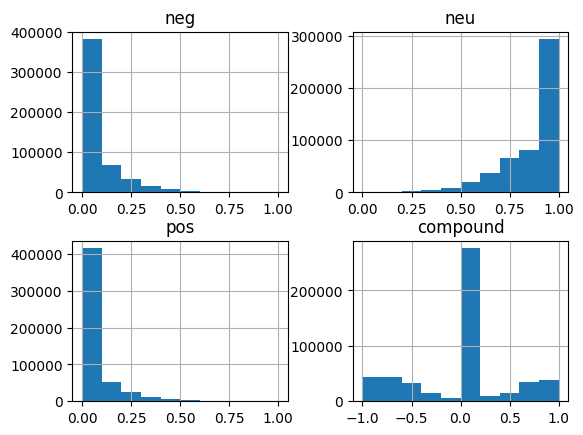

In [113]:
reviews.hist();

Как видим, признаки расположены ненормально, поэтому используем корреляцию Спирмена, чтобы посмотреть, есть ли среди них мультиколлинеарность.

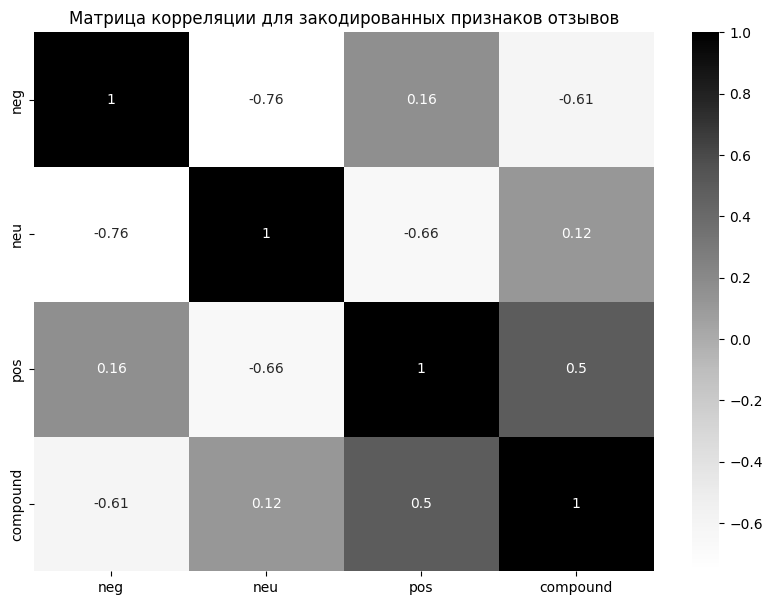

In [115]:
plt.figure(figsize=(10, 7))
corr_heatmap = sns.heatmap(reviews.corr(numeric_only=True, method='spearman'), annot=True, cmap='Greys')
corr_heatmap.set_title('Матрица корреляции для закодированных признаков отзывов');

Мультиколлинеарность не наблюдается, пока можем оставить данные признаки.